<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Load-the-data" data-toc-modified-id="Load-the-data-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Load the data</a></span><ul class="toc-item"><li><span><a href="#Label-mapping" data-toc-modified-id="Label-mapping-0.1.1"><span class="toc-item-num">0.1.1&nbsp;&nbsp;</span>Label mapping</a></span></li></ul></li></ul></li><li><span><a href="#Classifier" data-toc-modified-id="Classifier-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Classifier</a></span><ul class="toc-item"><li><span><a href="#Training-the-model" data-toc-modified-id="Training-the-model-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Training the model</a></span></li><li><span><a href="#Save-the-checkpoint" data-toc-modified-id="Save-the-checkpoint-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Save the checkpoint</a></span></li><li><span><a href="#Loading-the-checkpoint" data-toc-modified-id="Loading-the-checkpoint-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Loading the checkpoint</a></span></li></ul></li><li><span><a href="#Inference-for-classification" data-toc-modified-id="Inference-for-classification-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Inference for classification</a></span><ul class="toc-item"><li><span><a href="#Image-Preprocessing" data-toc-modified-id="Image-Preprocessing-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Image Preprocessing</a></span></li><li><span><a href="#Class-Prediction" data-toc-modified-id="Class-Prediction-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Class Prediction</a></span></li><li><span><a href="#Sanity-Checking" data-toc-modified-id="Sanity-Checking-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Sanity Checking</a></span></li></ul></li></ul></div>

In [89]:
# Imports
import numpy as np
import os
import sys
import torch
import json
import time
import copy
import random
from PIL import Image
from torch import nn, optim
from torch.autograd.variable import Variable as V
from torchvision import datasets, transforms, models, transforms, utils
from matplotlib import pyplot as plt
from matplotlib import gridspec
from collections import OrderedDict
from lr_finder import *

%matplotlib inline

In [2]:
#os.environ["CUDA_VISIBLE_DEVICES"]="0"
print(sys.version) # Python version
print(torch.cuda.device(0))
torch.cuda.get_device_name(0)

3.6.7 |Anaconda custom (64-bit)| (default, Oct 23 2018, 19:16:44) 
[GCC 7.3.0]


'GeForce GTX 1060'

In [3]:
seed=33
torch.manual_seed(seed)
print("Random Seed: ", seed)

Random Seed:  33


## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). You can [download the data here](https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip). The dataset is split into two parts, training and validation. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. If you use a pre-trained network, you'll also need to make sure the input data is resized to 224x224 pixels as required by the networks.

The validation set is used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks available from `torchvision` were trained on the ImageNet dataset where each color channel was normalized separately. For both sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.

In [4]:
# Datasets
data_dir='flower_data'
train_dir=data_dir + '/train'
valid_dir=data_dir + '/valid'

# Batch Size
bs=64

# Normalization parameters
means=[0.485,0.456,0.406] # ImageNet means
standard_deviations=[0.229,0.224,0.225] # ImageNet standard deviations


data_transforms={
    'train': transforms.Compose([transforms.RandomResizedCrop(224),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.RandomRotation(10),
                                    transforms.ToTensor(),
                                    transforms.Normalize(means,standard_deviations)]),    

    'valid': transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(means,standard_deviations)])
}

# ImageFolder
image_datasets=dict()
image_datasets['train']=datasets.ImageFolder(train_dir,transform=data_transforms['train'])
image_datasets['valid']=datasets.ImageFolder(valid_dir,transform=data_transforms['valid'])

# DataLoaders
dataloader=dict()
dataloader['train']=torch.utils.data.DataLoader(dataset=image_datasets['train'], 
                                                batch_size=bs,shuffle=True,drop_last=False)
dataloader['valid']=torch.utils.data.DataLoader(dataset=image_datasets['valid'],batch_size=bs)

#Dataset sizes
dataset_sizes={
    x:len(dataloader[x].dataset) for x in list(image_datasets.keys())}

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [5]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Classifier

In [6]:
model=models.densenet121(pretrained=True)
print(model)

for param in model.parameters():
    param.requires_grad=False # Freeze layers to avoid training them

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

/home/nsrishankar/miniconda3/envs/custom_dl_env/lib/python3.6/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [7]:
# Replacing the final FC layer with our classification layer
classifier_dict=OrderedDict([
    ('fc1', nn.Linear(1024,512,bias=True)),
    ('lrelu1', nn.LeakyReLU(0.2)),
    ('drop1', nn.Dropout(p=0.5)),
    ('fc2', nn.Linear(512,256,bias=True)),
    ('lrelu2', nn.LeakyReLU(0.2)),
    ('drop2', nn.Dropout(p=0.25)),
    ('fc3', nn.Linear(256,64,bias=True)),
    ('lrelu3', nn.LeakyReLU(0.2)),
    ('drop3', nn.Dropout(p=0.25)),
    ('output', nn.Linear(64,102, bias=True)),
    ('softmax', nn.LogSoftmax(dim=1))
])

classifier=nn.Sequential(classifier_dict) # Final classifier 'layer'
model.classifier=classifier
print(model) # print model
model.cuda() # Running on GPU

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

Stopping early


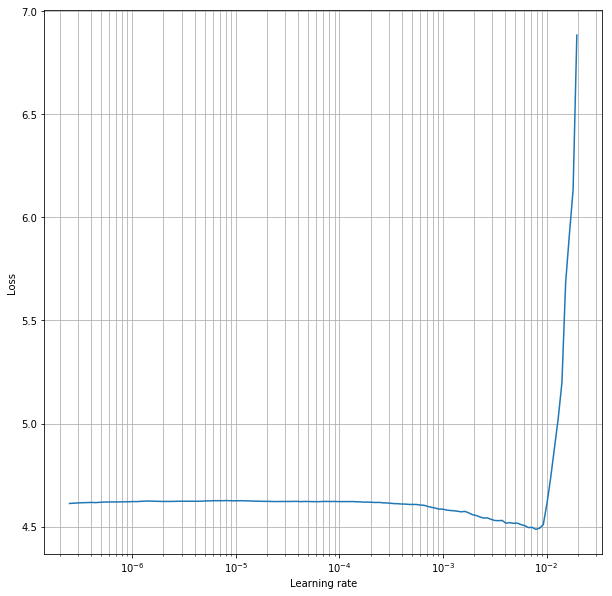

In [8]:
l_rate=1e-7 # Initial learning rate before using a Learning rate finder
criterion=nn.NLLLoss() #Negative Log-Likelihood loss function
# Also training the final "FC" layer
optimizer=optim.Adam(model.classifier.parameters(),lr=l_rate) # Adam Optimizer

lr_finder=LRFinder(model,optimizer,criterion,device="cuda")
lr_finder.range_test(dataloader['train'],end_lr=100,num_iter=250)
lr_finder.plot()

In [9]:
# Set new learning rate for optimizer
l_rate=1e-3#0.095
optimizer=optim.Adam(model.classifier.parameters(),lr=l_rate) # Adam Optimizer

# Instead of step or exponnential learning rate decay, using cosine annealing for better local minima choice
#scheduler=optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=10,eta_min=5e-3,last_epoch=-1)
scheduler=optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

## Training the model

In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloader[phase]:
                inputs = inputs.cuda()
                labels = labels.cuda()

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [11]:
num_epochs=50
save_directory='saved_weights/'

model=train_model(model,criterion,optimizer,scheduler,num_epochs)

if not os.path.exists(save_directory):
    os.makedirs(save_directory)
        
filepath_model="{}densenet121_model_epoch{}".format(save_directory,num_epochs)
torch.save(model,filepath_model)

Epoch 0/49
----------
train Loss: 46.4828 Acc: 0.0237
valid Loss: 6.7260 Acc: 0.0501

Epoch 1/49
----------
train Loss: 7.9474 Acc: 0.0446
valid Loss: 4.1295 Acc: 0.1247

Epoch 2/49
----------
train Loss: 5.1619 Acc: 0.0818
valid Loss: 3.4301 Acc: 0.2689

Epoch 3/49
----------
train Loss: 4.1556 Acc: 0.1364
valid Loss: 3.0069 Acc: 0.3203

Epoch 4/49
----------
train Loss: 3.6513 Acc: 0.1925
valid Loss: 2.6909 Acc: 0.4083

Epoch 5/49
----------
train Loss: 3.3013 Acc: 0.2419
valid Loss: 2.3523 Acc: 0.4597

Epoch 6/49
----------
train Loss: 3.0357 Acc: 0.2924
valid Loss: 2.0185 Acc: 0.5636

Epoch 7/49
----------
train Loss: 2.7647 Acc: 0.3411
valid Loss: 1.8512 Acc: 0.5660

Epoch 8/49
----------
train Loss: 2.5739 Acc: 0.3784
valid Loss: 1.5900 Acc: 0.6259

Epoch 9/49
----------
train Loss: 2.4086 Acc: 0.4132
valid Loss: 1.3800 Acc: 0.6577

Epoch 10/49
----------
train Loss: 2.2195 Acc: 0.4484
valid Loss: 1.2058 Acc: 0.6980

Epoch 11/49
----------
train Loss: 2.1113 Acc: 0.4644
valid Los

## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [12]:
checkpoint_path='checkpoint_densenet121_epoch{}_lr{}'.format(num_epochs,l_rate)

model.class_to_idx=dataloader['train'].dataset.class_to_idx

checkpoint={
    'model': 'densenet121',
    'epoch': num_epochs,
    'state_dict': model.state_dict(),
    'optimizer_dict': optimizer.state_dict(),
    'class2idx': model.class_to_idx
}

torch.save(checkpoint,checkpoint_path)

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [13]:
def load_checkpoint(checkpoint_path):
    checkpoint=torch.load(checkpoint_path) # Load saved checkpoint
    
    # Reconstruct network
    model=models.densenet121(pretrained=True)
    for param in model.parameters():
        param.requires_grad=False
        
    # Replacing the final FC layer with our classification layer
    classifier_dict=OrderedDict([
    ('fc1', nn.Linear(1024,512,bias=True)),
    ('lrelu1', nn.LeakyReLU(0.2)),
    ('drop1', nn.Dropout(p=0.5)),
    ('fc2', nn.Linear(512,256,bias=True)),
    ('lrelu2', nn.LeakyReLU(0.2)),
    ('drop2', nn.Dropout(p=0.25)),
    ('fc3', nn.Linear(256,64,bias=True)),
    ('lrelu3', nn.LeakyReLU(0.2)),
    ('drop3', nn.Dropout(p=0.25)),
    ('output', nn.Linear(64,102, bias=True)),
    ('softmax', nn.LogSoftmax(dim=1))
    ])

    classifier=nn.Sequential(classifier_dict) # Final classifier 'layer'
    model.fc=classifier # Replace the previous Full-Connected Layer with the new classifier layer of a right size

    model.cuda() # Running on GPU
    
    # Loading checkpoints
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(state['optimizer_dict'])
    model.class_to_idx=checkpoint['class_to_idx']
    return model, optimizer

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [14]:
def process_image(image_path):
    means=[0.485,0.456,0.406]
    standard_deviations=[0.229,0.224,0.225]
    
    raw_image=Image.open(image_path).convert('RGB')
    
    image_transforms=transforms.Compose([transforms.Resize(256),
                                         transforms.CenterCrop(224),
                                         transforms.ToTensor(),
                                         transforms.Normalize(means,standard_deviations)])    
    
    return image_transforms(raw_image)

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [15]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    plt.axis('off')
    return ax

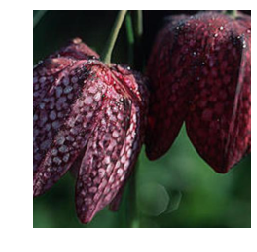

In [16]:
sample_image_location='sample_image.jpg'
imshow(process_image(sample_image_location))

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [77]:
def predict(image_path, model, topk=5):
    model.to("cpu")
    model.eval() # Evaluate model
    
    raw_image=np.expand_dims(process_image(image_path),axis=0)
    tensor=V(torch.from_numpy(raw_image))
    
    log_probs=model.forward(tensor) # Log probs
    linear_prob=torch.exp(log_probs) # to a linear scale
    top_probs,top_labels=linear_prob.topk(topk)
    idx2class={model.class_to_idx[k]: k for k in model.class_to_idx}
    top_label_names=list()
    top_probs_out=list()
    for label in top_labels.numpy()[0]:
        top_label_names.append(idx2class[label])
    for prob in top_probs.detach().numpy()[0]:
        top_probs_out.append(prob)
    return top_probs_out,top_label_names

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the validation accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [78]:
image_path_one='sample_image.jpg'
image_path_two='sample_image2.jpg'
image_path_three='sample_image3.jpg'
# Predict images for the three sample images
top_probs_1,top_label_names_1=predict(image_path_one,model)
top_probs_2,top_label_names_2=predict(image_path_two,model)
top_probs_3,top_label_names_3=predict(image_path_three,model)

In [79]:
print(top_probs_1)
print(top_label_names_1)

[0.9999981, 6.240074e-07, 5.066409e-07, 2.3052522e-07, 1.7500844e-07]
['23', '20', '35', '102', '25']


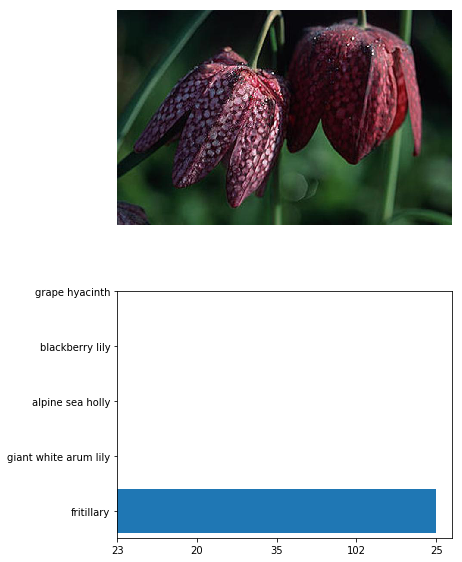

In [85]:
fig,(ax1, ax2) = plt.subplots(figsize=(6,10),ncols=1,nrows=2)
ax1.imshow(Image.open(image_path_one).convert('RGB'))
ax1.axis('off')

probs=np.arange(len(top_probs_1))
ax2.barh(top_probs_1,top_label_names_1)
ax2.set_yticks(probs)
ax2.set_yticklabels(cat_to_name[lab] for lab in top_label_names_1)
plt.show()

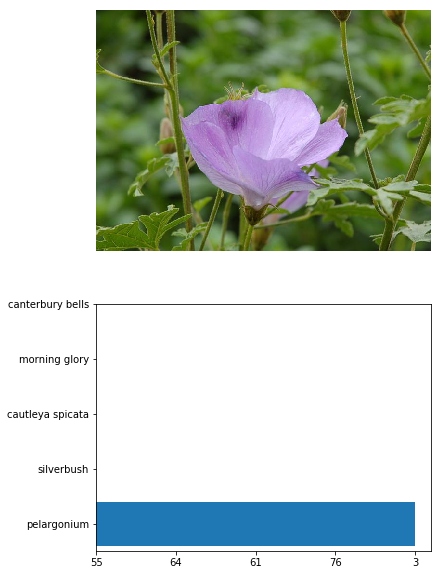

In [87]:
fig,(ax1, ax2) = plt.subplots(figsize=(6,10),ncols=1,nrows=2)
ax1.imshow(Image.open(image_path_two).convert('RGB'))
ax1.axis('off')

probs=np.arange(len(top_probs_2))
ax2.barh(top_probs_2,top_label_names_2)
ax2.set_yticks(probs)
ax2.set_yticklabels(cat_to_name[lab] for lab in top_label_names_2)
plt.show()

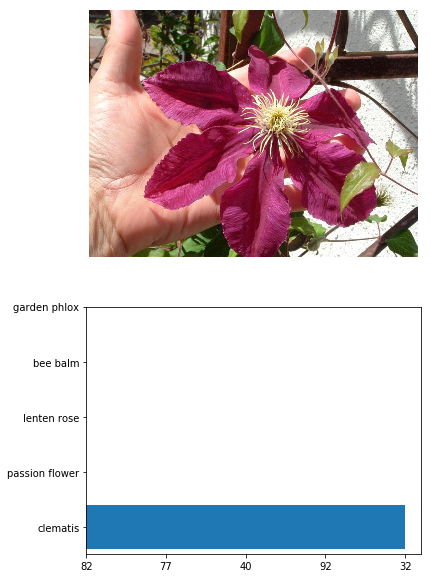

In [88]:
fig,(ax1, ax2) = plt.subplots(figsize=(6,10),ncols=1,nrows=2)
ax1.imshow(Image.open(image_path_three).convert('RGB'))
ax1.axis('off')

probs=np.arange(len(top_probs_3))
ax2.barh(top_probs_3,top_label_names_3)
ax2.set_yticks(probs)
ax2.set_yticklabels(cat_to_name[lab] for lab in top_label_names_3)
plt.show()

/home/nsrishankar/miniconda3/envs/custom_dl_env/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: This function is deprecated. Please call randint(1, 103 + 1) instead
  """Entry point for launching an IPython kernel.


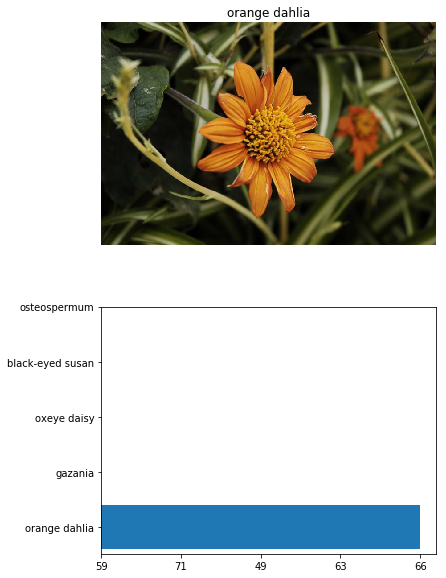

In [109]:
random_img_folder=np.random.random_integers(1,103)
flower=cat_to_name[str(random_img_folder)]
random_image_folder_path=train_dir+'/'+str(random_img_folder)+'/'

random_image=random.choice(os.listdir(random_image_folder_path))
random_image_path=random_image_folder_path+random_image

top_probs_rnd,top_label_names_rnd=predict(random_image_path,model)

fig,(ax1, ax2) = plt.subplots(figsize=(6,10),ncols=1,nrows=2)
ax1.imshow(Image.open(random_image_path).convert('RGB'))
ax1.set_title(flower)
ax1.axis('off')

probs=np.arange(len(top_probs_rnd))
ax2.barh(top_probs_rnd,top_label_names_rnd)
ax2.set_yticks(probs)
ax2.set_yticklabels(cat_to_name[lab] for lab in top_label_names_rnd)
plt.show()